In [2]:
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
from pycbc.psd import estimate
from pycbc.types import TimeSeries
import emcee
import corner
import time
from multiprocessing import Pool
from multiprocessing import cpu_count
import scipy

# In the cell i am sorting the data to windowing and making psd

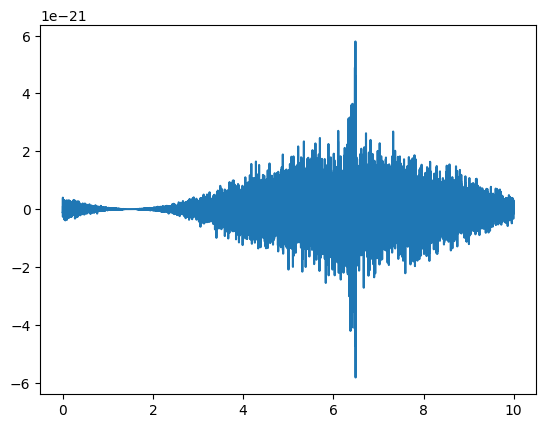

/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


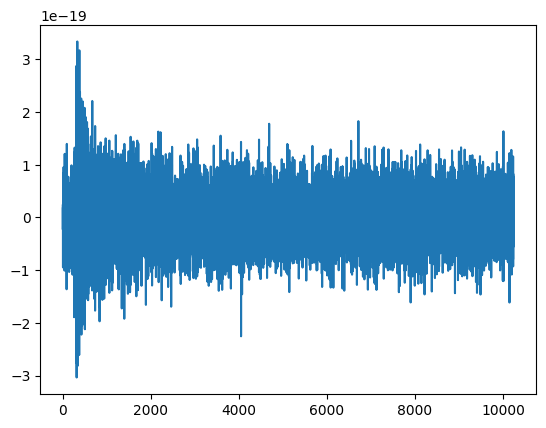

In [3]:
# loading in data 
time_data, strain_data = np.loadtxt('data/PE_unknown_white_data_ts.txt',skiprows = 1).T
time_noise, strain_noise = np.loadtxt('data/PE_unknown_white_noise_ts.txt',skiprows=1).T


# converting to time series
strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])


# rolling to the middle and windowing and rolling back to 8 seconds
mid_point = len(strain_data) /2
final_point = len(strain_data)
peaks,_ = find_peaks(strain_data,height = 3e-21,distance = 1000)
roll_amount = mid_point - peaks
centred = np.roll(strain_data,int(roll_amount))
delta_t = time_data[1] - time_data[0]
window = signal.windows.hann(len(centred))
centred_windowed_signal = centred*window
centred_windowed_signal_final = np.roll(centred_windowed_signal,-int(roll_amount))
plt.plot(time_data,centred_windowed_signal_final)
plt.show()
#defining main data and shaping
data_freq = np.fft.rfft(centred_windowed_signal_final) 
freq_array = np.fft.rfftfreq(len(time_data),delta_t)
plt.plot(data_freq)
delta_f = freq_array[1]-freq_array[0]

high_cutoff = 1000
low_cutoff = 30

high_limit = 1000/delta_f+1
low_limit = 30/delta_f

data_final = data_freq[:int(high_limit)]
freq_final = freq_array[:int(high_limit)]

data_final[freq_final < low_cutoff] = 0 

#defing psd
delta_t = time_data[1] - time_data[0]
duration = len(strain_data)*delta_t
seg_len = len(strain_noise_ts) // 4
seg_stride = seg_len // 2

psd = estimate.welch(strain_noise_ts,window = 'hann' ,seg_len=seg_len,seg_stride = seg_stride)
psd_freqs = np.fft.fftfreq(len(psd), d=delta_t)  

interp_psd = interp1d(psd_freqs, psd, kind='linear', bounds_error=False, fill_value="extrapolate")
psd_interpolated = interp_psd(freq_array[:int(high_limit)]) 


In [4]:
# plt.plot(time_data,centred_windowed_signal)

In [5]:
# plt.plot(data_final)
# print(len(data_final))

# defining the template

In [8]:
def template(theta,delta_t,f_lower,f_higher,delta_f):
    M1,M2,D,time_shift,E,phi = theta 

    hplus , hc = get_fd_waveform(mass1 = M1,
                                 mass2 = M2,
                                 distance = D, 
                                 eccentricity = E,
                                 spin1x = phi,
                                 approximant='IMRPhenomPv2',
                                 f_lower=f_lower, 
                                 f_higher=f_higher, 
                                 delta_t = delta_t,
                                 delta_f = delta_f)

    hplus= hplus.cyclic_time_shift(time_shift)
    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
        return hplus
    
    if len(hplus) == len(data_final):
        return hplus
    
    if len(hplus) < len(data_final):
        pad_amount = len(data_final) - len(hplus)
        hplus = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
        return hplus

[ 0.+0.j -0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]


/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


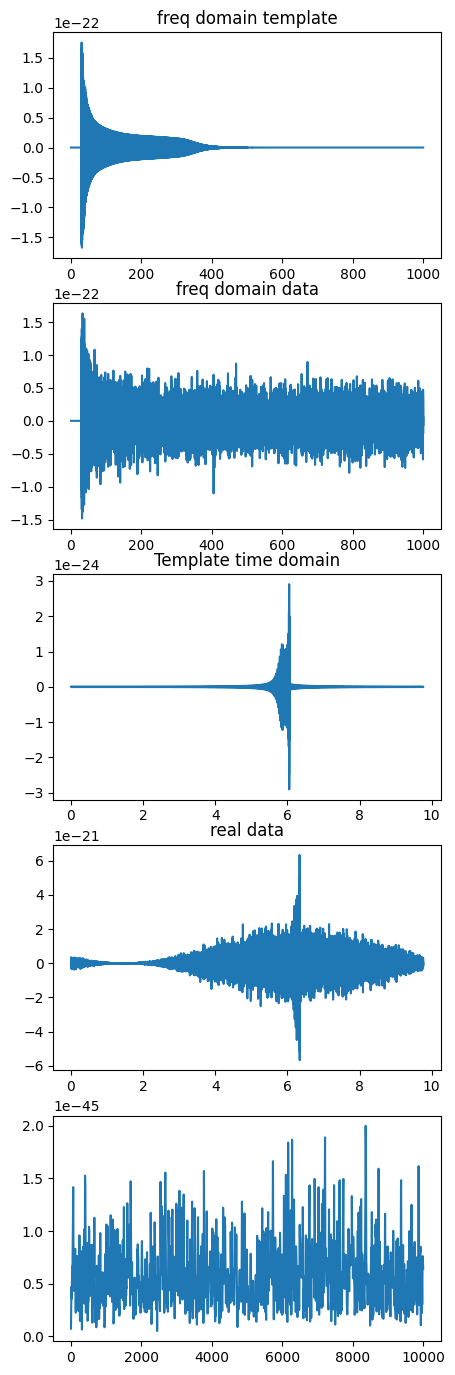

In [10]:
theta = 35,20,100,6.2,0.5,0.9
temp = template(theta,delta_t,30,1000,delta_f)#0.00873
print(temp)
plt.figure(figsize = (5,17))
plt.subplot(511)
plt.plot(freq_final,temp)
plt.title('freq domain template')

plt.subplot(512)
plt.plot(freq_final, data_final*delta_t)
plt.title('freq domain data')

plt.subplot(513)
plt.plot(time_data[:20000],np.fft.irfft(temp))
plt.title('Template time domain')

plt.subplot(514)
plt.plot(time_data[:20000],np.fft.irfft(data_final))
plt.title('real data')

plt.subplot(515)
plt.plot(psd_interpolated)

In [11]:
#

# Defining the prior in log space

In [12]:
def log_prior(theta):
    M1,M2,D,time_shift,E,phi = theta
    
    if not(33 < M1 < 37):
        return - np.inf
    
    if not(46 < M2 < 50):
        return -np.inf 
    
    if not(168 < D < 172):
        return -np.inf
    
    if not(6.4 < time_shift < 6.6):
        return -np.inf
    
    if not(0< E, 1):
        return -np.inf
    
    if not(0< phi < 1):
        return -np.inf


    # if not(0<f_lower<1000):
    #     return -np.inf
    
    # if not(f_lower<f_higher<4000):
    #     return -np.inf
    
    return 0 + 2*np.log(D) + np.log(np.sin(phi))



# Defining the log likelihood function

In [13]:
def log_like(theta, fft_signal,noise ,delta_t,delta_f):

    
    temp = template(theta, delta_t , 30, 1000,delta_f)

    residual = fft_signal*delta_t - temp
    summation = np.abs(residual)**2/noise
    return -2 / duration * sum((summation))

# Defining the log posterior

In [14]:
def log_posterior(theta, data,noise_data,delta_t,delta_f):
    # print(f"Theta: {theta}")
    log_pri = log_prior(theta)
    if np.isinf(log_pri):  # if prior is -inf, return stragiht away
        return log_pri
    return log_pri + log_like(theta, data, noise_data,delta_t,delta_f)

# running the mcmc

In [ ]:
# nwalkers = 30
# ndim = 3

# initial = np.empty((nwalkers, ndim)) 
# initial[:, 0] = np.random.uniform(30, 34, size=nwalkers)
# initial[:, 1] = np.random.uniform(28, initial[:, 0])
# initial[:, 2] = np.random.uniform(80, 150, size=nwalkers)

# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args = (data_final,psd_interpolated,delta_t,delta_f), pool=pool)
#     start = time.time()
#     sampler.run_mcmc(initial, 2000, progress=True)
#     sampler.reset()
#     # running the mcmc
#     nsteps = 2000
#     sampler.run_mcmc(initial, nsteps,progress = True)
#     end = time.time()
#     multi_time = end - start


In [17]:
# defining the number of walkers in the mcmc chain and th number of dimensions (parameters)
nwalkers = 32
ndim = 6

# defining intitial array of guess (theta guesses)
initial = np.empty((nwalkers, ndim)) 
initial[:, 0] = np.random.uniform(33,37 , size=nwalkers)
initial[:, 1] = np.random.uniform(46, 50, size = nwalkers)#initial[:, 0])
initial[:, 2] = np.random.uniform(168, 172, size=nwalkers)
initial[:,3] = np.random.uniform(6.4,6.6, size = nwalkers)
initial[:,4] = np.random.uniform(0,1, size = nwalkers)
initial[:,5] = np.random.uniform(0,1, size = nwalkers)

#running the emcee sampelr
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_final,psd_interpolated,delta_t,delta_f))#,moves= emcee.moves.StretchMove())

#running the burn - in stage of the mcmc chain to allow the walker tp explore the space
state = sampler.run_mcmc(initial, nsteps = 1500,progress = True)
sampler.reset()
# running the mcmc

nsteps = 1500
sampler.run_mcmc(initial, nsteps,progress = True)

100%|██████████| 1500/1500 [07:04<00:00,  3.53it/s]


State([[ 3.30238800e+01  4.93369582e+01  1.71973004e+02  6.49220805e+00
   3.06890461e+03  9.97083476e-01]
 [ 3.34240871e+01  4.79250677e+01  1.71923709e+02  6.55359767e+00
  -3.97192553e+00  9.87812853e-01]
 [ 3.34830474e+01  4.79616848e+01  1.71760644e+02  6.55356345e+00
   8.52056002e+00  9.99336023e-01]
 [ 3.30648855e+01  4.93203865e+01  1.71905605e+02  6.49230951e+00
  -4.67795535e+03  9.97321415e-01]
 [ 3.30066103e+01  4.93755568e+01  1.71606443e+02  6.49225451e+00
  -1.88654141e+02  9.79548909e-01]
 [ 3.30300079e+01  4.93196321e+01  1.71068560e+02  6.49217036e+00
  -5.37015776e+03  9.88103140e-01]
 [ 3.30509440e+01  4.81598510e+01  1.71394564e+02  6.55355336e+00
   4.53706022e+00  9.88406367e-01]
 [ 3.33831289e+01  4.75880486e+01  1.71500202e+02  6.55302742e+00
   1.86918325e+01  9.91735491e-01]
 [ 3.30288365e+01  4.92481816e+01  1.71985332e+02  6.49212205e+00
   4.19075431e+03  9.97062651e-01]
 [ 3.34168983e+01  4.77048431e+01  1.71535309e+02  6.55334237e+00
   1.27114857e+01  

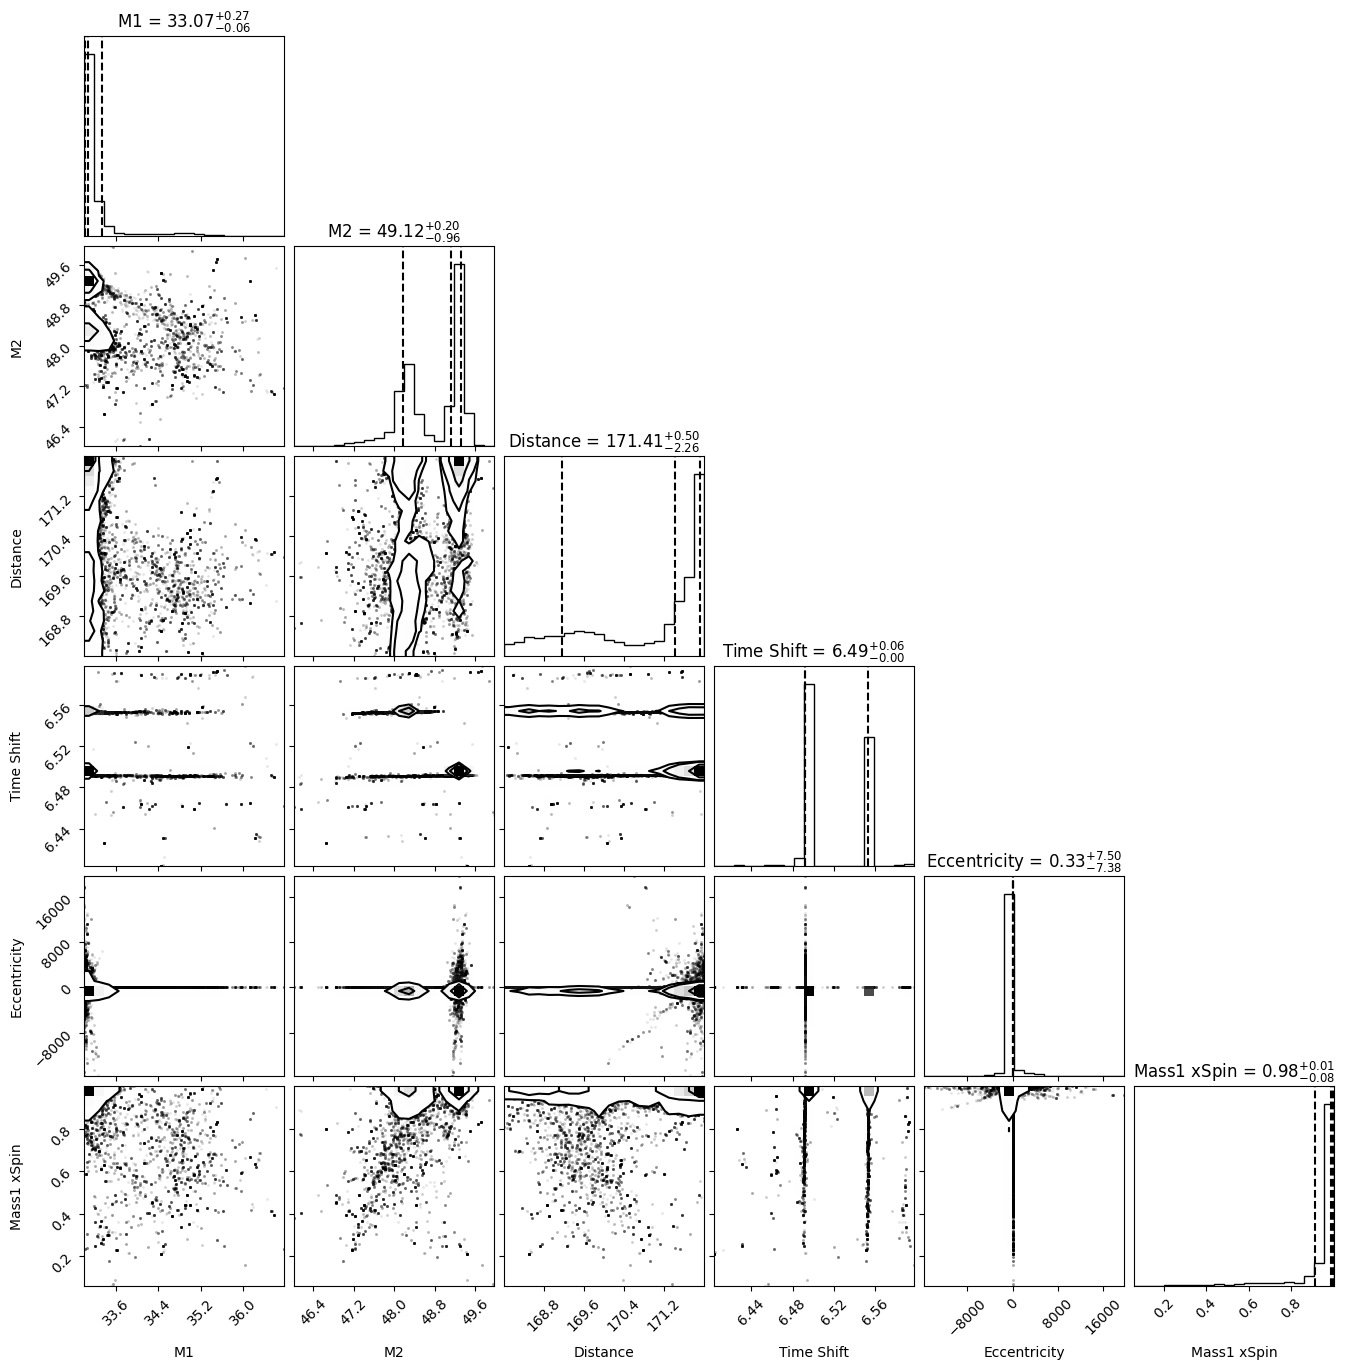

In [18]:
# this is with delta_t multiplied to template

samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift','Eccentricity','Mass1 xSpin'],quantiles=[0.16,0.5,0.84],show_titles = True)


# figure.savefig("corner_plot_M1_M2_D_time.jpg", format="jpeg", dpi=300)

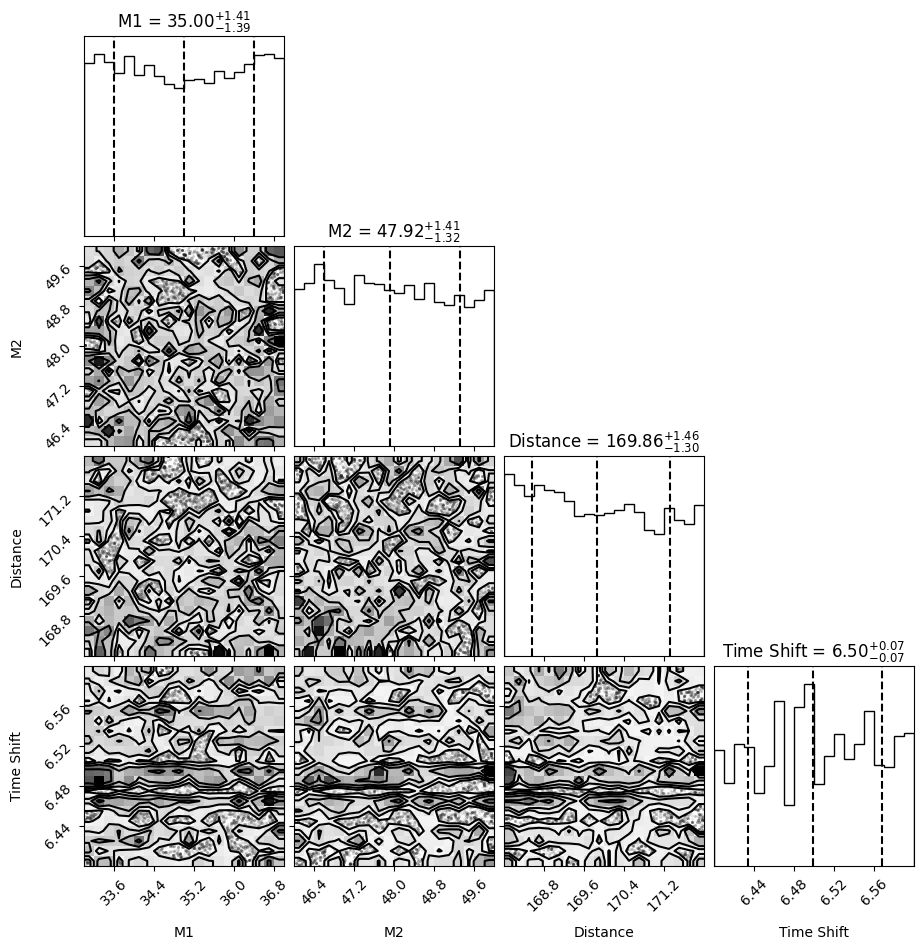

In [71]:
# this is with delta_t multiplied to both signal and template 

samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)

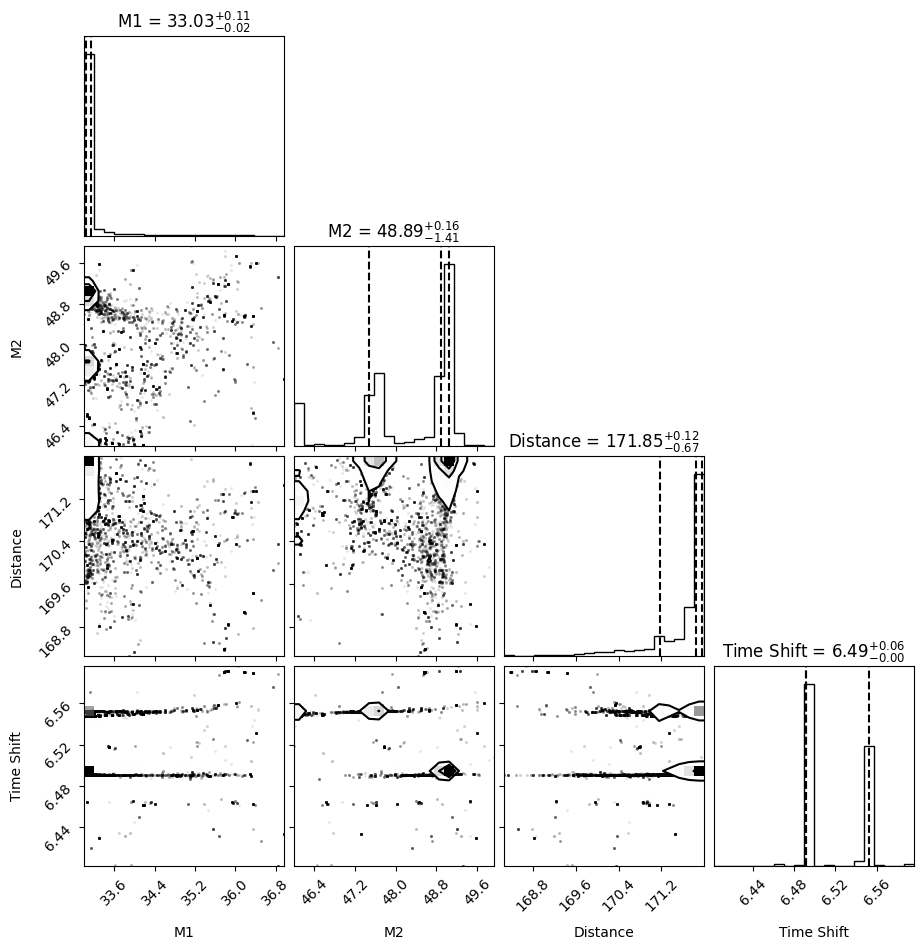

In [76]:
# this is with delta_t mulitpled to signal
samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)

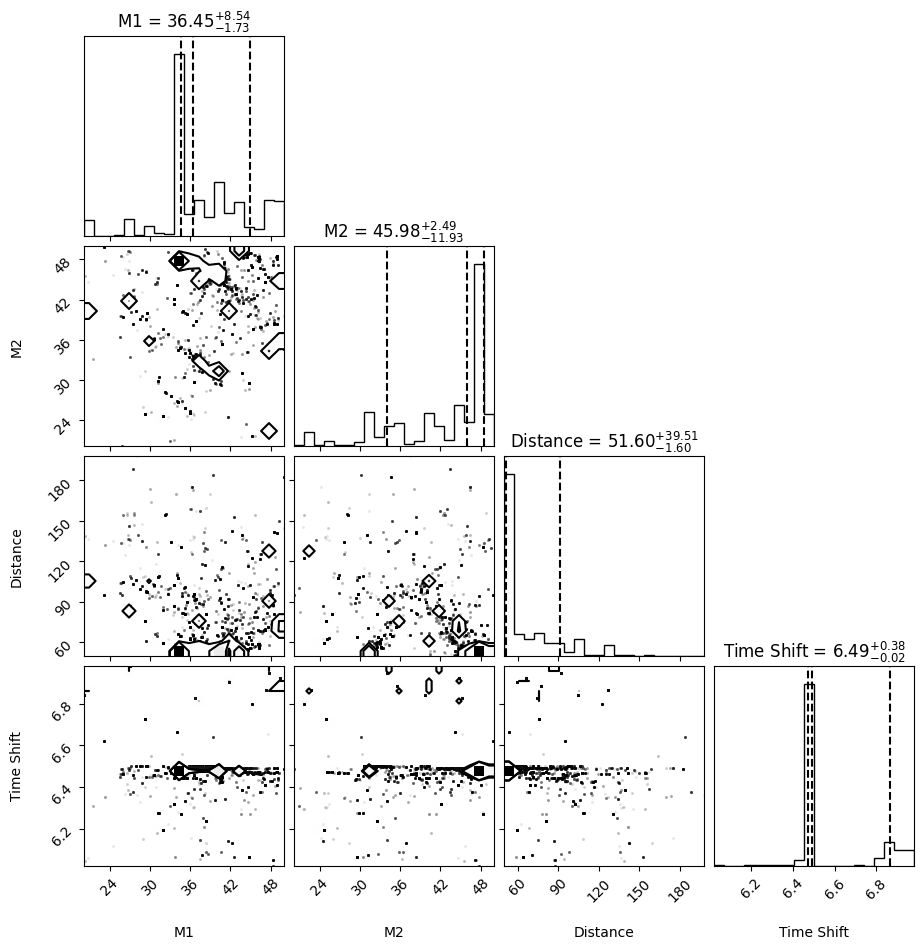

In [ ]:
samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)

# figure.savefig("corner_plot_unknown_M1_M2_D_time_largeprior.jpg", format="jpeg", dpi=300)

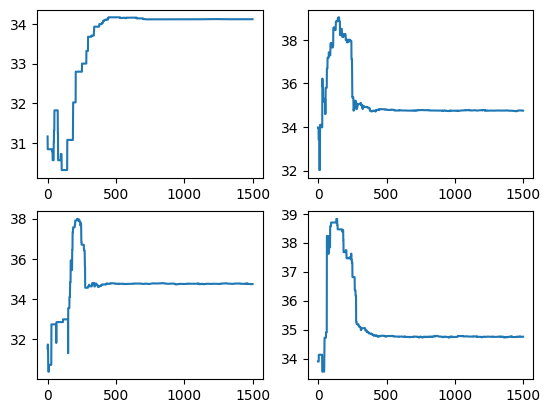

In [53]:
samples = sampler.get_chain()


plt.subplot(221)
plt.plot(samples[:,4,0])
plt.subplot(222)
plt.plot(samples[:,3,0])
plt.subplot(223)
plt.plot(samples[:,2,0])
plt.subplot(224)
plt.plot(samples[:,1,0])

# plotting the mcmc results

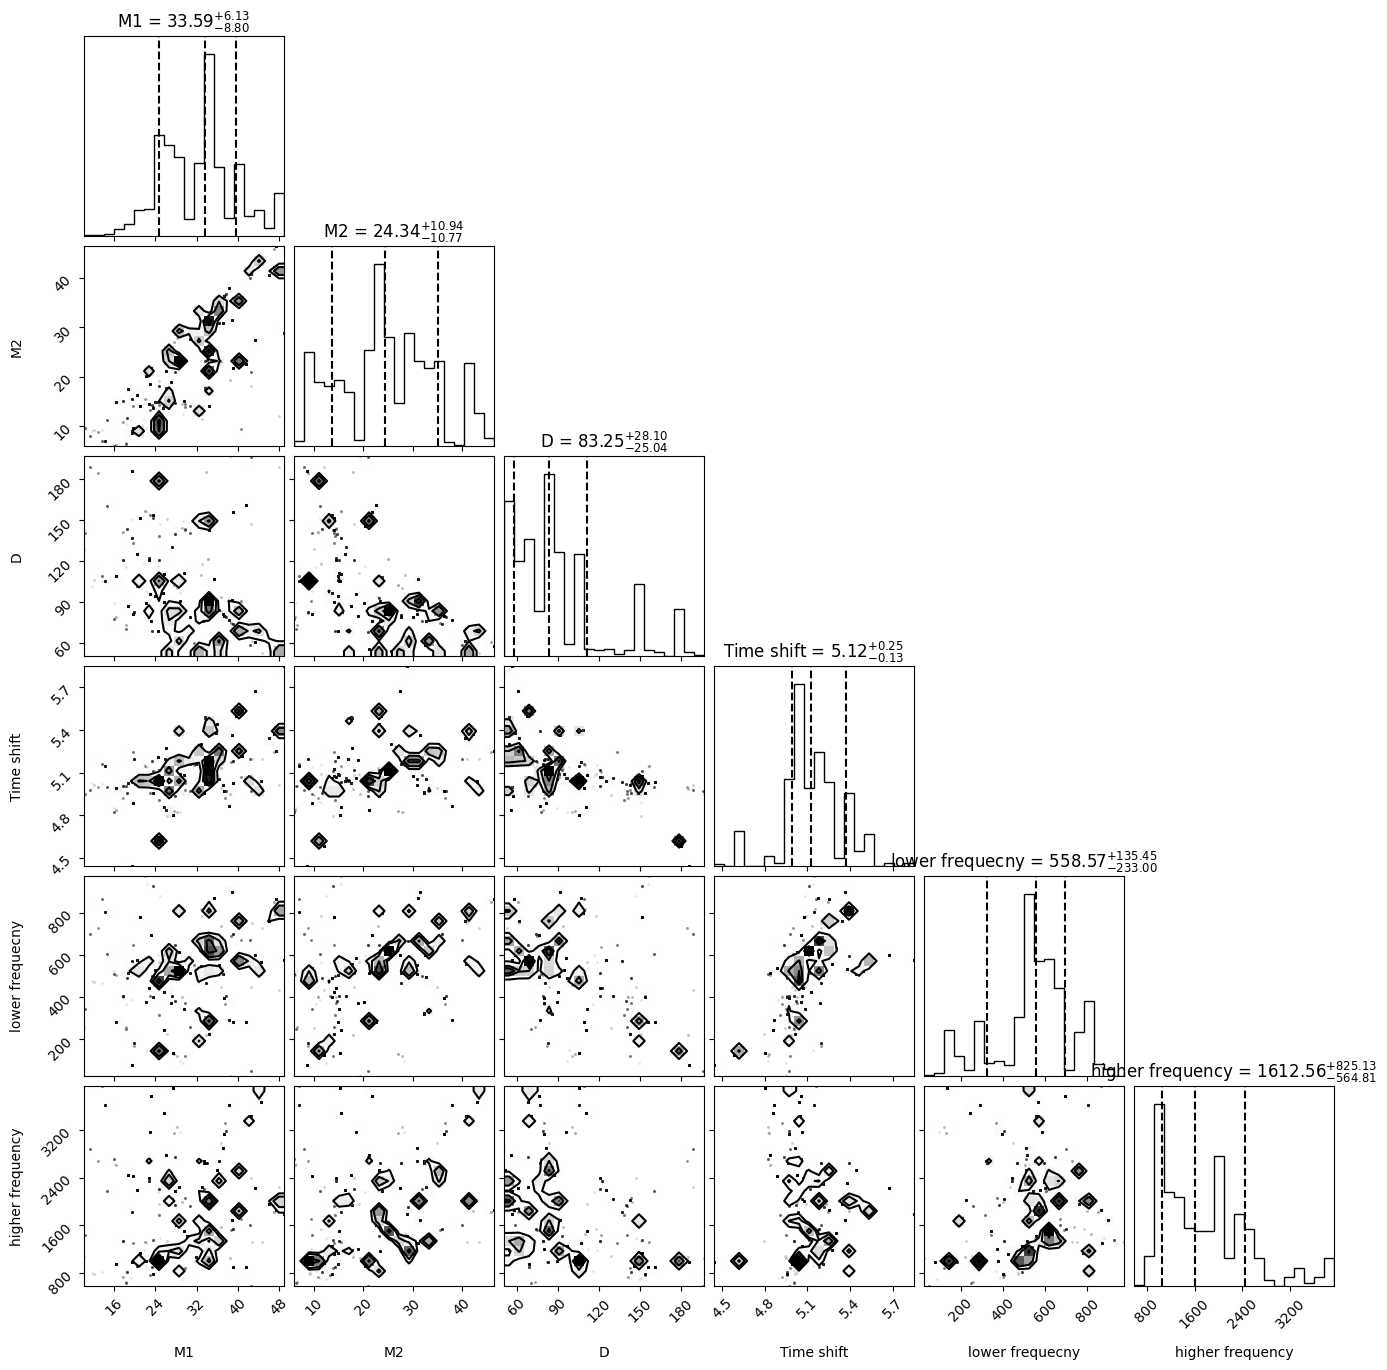

In [114]:
# this was 10 walkers, 1500 burn in, and 500 steps
samples = sampler.flatchain
# samples = sampler.get_chain(flat=True)
# samples = sampler.get_chain()


figure = corner.corner(samples,labels = ['M1','M2','D','Time shift','lower frequecny','higher frequency'],quantiles=[0.16,0.5,0.84],show_titles = True)

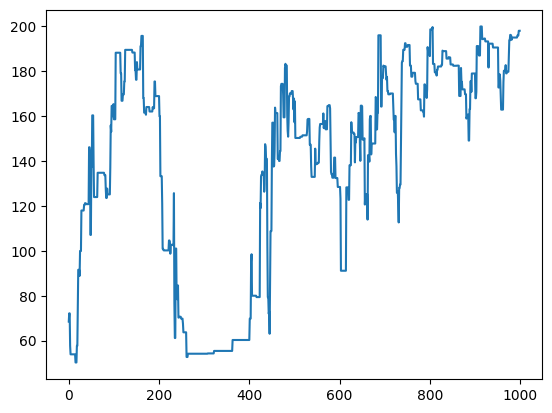

In [24]:
samples = sampler.get_chain()

plt.plot(samples[:,5,2])